# Difference in significance between `cash` and `wstat` analysis

Method:
- Simultate an extended gaussian using the IRF background (`MapDataset`)
- Create a `MapDatasetOnOff` from the thus simulated `MapDataset` using the `RingBackGroundMaker`
- Fit these datasets, use the `ExcessMapEstimator` to see contours
- Compare the results for the two cases

Standard imports

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.makers import RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator
from regions import CircleSkyRegion
from scipy.stats import norm, chi2
from gammapy.maps import Map

## Do a binned simulation using DC1 IRFs

In [2]:
# Load the irfs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

# Define the observation parameters
livetime = 1.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 2), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(4, 4),
    frame="galactic",
    axes=[energy_reco],
)

In [3]:
# Define sky model to used simulate the data.

spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.4 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="5e-13 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model_simu",
)

In [4]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
empty = MapDataset.create(geom, name="dataset-simu")
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
dataset.models.append(model_simu)
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 48551 
  Total predicted counts          : 48016.35
  Total background counts         : 47221.95

  Exposure min                    : 2.13e+09 m2 s
  Exposure max                    : 3.28e+09 m2 s

  Number of total bins            : 40000 
  Number of fit bins              : 40000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 77807.22

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: BackgroundModel
  
    Name                      : dataset-simu-bkg
    Datasets names            : ['dataset-simu']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  Component 1: SkyModel
  
    Name                      : model_simu
    Datasets name

In [5]:
estimator = ExcessMapEstimator(0.4 * u.deg)

## Cash statistics - fitting and excess maps

In [6]:
# Make a copy of the dataset
dataset_fit = dataset.copy(name="dataset-fit")

In [7]:
dataset_fit.models["dataset-simu-bkg"].datasets_names = ["dataset-fit"]
dataset_fit.models.remove('model_simu')

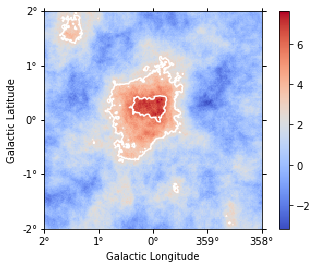

In [8]:
#Plot the significance maps
lima_cash = estimator.run(dataset_fit, steps="ts")
fig, ax, _ = lima_cash['significance'].sum_over_axes().plot(add_cbar=True,
                                           cmap='coolwarm')
d = np.squeeze(lima_cash['significance'].sum_over_axes().data)
ax.contour(d, colors="white", levels=[3, 6])

In [9]:
L0 = dataset_fit.stat_sum()

### Do the fitting

In [10]:
# Define sky model to fit the data
spatial_model1 = GaussianSpatialModel(
    lon_0="0.1 deg", lat_0="0.1 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model1 = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(
    spatial_model=spatial_model1,
    spectral_model=spectral_model1,
    name="model-fit",
)
model_fit.spectral_model.parameters['index'].frozen = True
dataset_fit.models = [model_fit, dataset_fit.models[0]]


In [11]:
%%time
fit = Fit([dataset_fit])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 7.78E+04                |     Ncalls=153 (153 total)     |
| EDM = 8.26E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1.67 s, sys: 13 ms, total: 1.68 s
Wall time: 1.68 s


In [12]:
L1 = dataset_fit.stat_sum()
print("significance of detection = ", L0 - L1, " p-value =", chi2.sf(L0-L1, 5))

significance of detection =  90.80703453098249  p-value = 4.547453276823e-18


In [13]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,3.000e+00,,nan,nan,True,0.000e+00
amplitude,4.329e-13,cm-2 s-1 TeV-1,nan,nan,False,8.968e-14
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
lon_0,1.226e-01,deg,nan,nan,False,7.416e-02
lat_0,1.942e-01,deg,-9.000e+01,9.000e+01,False,8.160e-02
sigma,4.146e-01,deg,0.000e+00,nan,False,5.617e-02
e,0.000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.000e+00,deg,nan,nan,True,0.000e+00
norm,1.014e+00,,0.000e+00,nan,False,5.473e-03


## WSTAT - Ring background

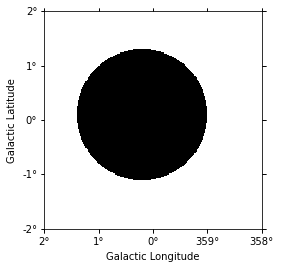

In [14]:
# Make the exclusion mask
source_pos = model_simu.position
regions = CircleSkyRegion(center=source_pos, radius=1.2 * u.deg)
exclusion_mask = Map.from_geom(geom)
exclusion_mask.data = geom.region_mask([regions], inside=False)
exclusion_mask.sum_over_axes().plot();

In [15]:
ring_maker = RingBackgroundMaker(
    r_in="1.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)
dataset_on_off = ring_maker.run(dataset)
dataset_on_off.psf = dataset.psf
L2 = dataset_on_off.stat_sum()

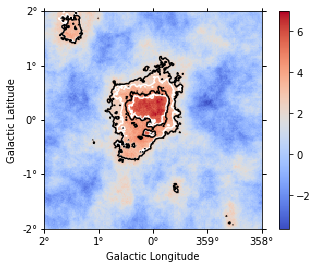

In [16]:
# Significance maps - white (wstat), black (cash)
lima_wstat = estimator.run(dataset_on_off, steps="ts")
fig, ax, _ = lima_wstat['significance'].sum_over_axes().plot(add_cbar=True,
                                           cmap='coolwarm')
d1 = np.squeeze(lima_wstat['significance'].data)
ax.contour(d1, colors="white", levels=[3,5])
ax.contour(d, colors="black", levels=[3,5])

## Do the fitting

In [17]:
# Define sky model to fit the data
spatial_model2 = GaussianSpatialModel(
    lon_0="0.1 deg", lat_0="0.1 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model2 = PowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit2 = SkyModel(
    spatial_model=spatial_model2,
    spectral_model=spectral_model2,
    name="model-fit2",
)
model_fit2.spectral_model.parameters['index'].frozen = True
model_fit2.datasets_names = dataset_on_off.name
dataset_on_off.models = model_fit2


No background model defined for dataset dataset-simu


In [18]:
print(dataset_on_off)

MapDatasetOnOff
---------------

  Name                            : dataset-simu 

  Total counts                    : 48551 
  Total predicted counts          : 1578.98
  Total background counts         : nan

  Exposure min                    : 2.13e+09 m2 s
  Exposure max                    : 3.28e+09 m2 s

  Number of total bins            : 40000 
  Number of fit bins              : 40000 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 46709.79

  Number of models                : 1 
  Number of parameters            : 8
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : model-fit2
    Datasets names            : dataset-simu
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : None
    Parameters:
      index        (frozen)   :   3.000              
      amplitude               :   1.00e-12  1 / (cm2 s TeV)
      r

In [19]:
%%time
fit2 = Fit([dataset_on_off])
result2 = fit2.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 4.666E+04               |     Ncalls=113 (113 total)     |
| EDM = 4.3E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1.52 s, sys: 84 ms, total: 1.61 s
Wall time: 1.61 s


In [20]:
result2.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,3.000e+00,,nan,nan,True,0.000e+00
amplitude,4.388e-13,cm-2 s-1 TeV-1,nan,nan,False,7.795e-14
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
lon_0,1.252e-01,deg,nan,nan,False,7.307e-02
lat_0,1.592e-01,deg,-9.000e+01,9.000e+01,False,8.522e-02
sigma,4.200e-01,deg,0.000e+00,nan,False,5.286e-02
e,0.000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.000e+00,deg,nan,nan,True,0.000e+00


In [21]:
L3 = dataset_on_off.stat_sum()
L1 = dataset_fit.stat_sum()
print("significance of detection = ", L2 - L3, " p-value =", chi2.sf(L2-L3, 4))

significance of detection =  63.82844901969656  p-value = 4.541632910618397e-13


In [22]:
## Compared with cash
print("significance of detection = ", L0 - L1, " p-value =", chi2.sf(L0-L1, 5))

significance of detection =  90.80703453098249  p-value = 4.547453276823e-18
